<div align="center">
    <h1><bold>DATA ACADEMY:</bold> Data essentials tools, Data modeling & Visualization.</h1>
</div>

# Setup

In [43]:
import pandas as pd
import sqlite3
import folium
import statistics as st

conn = sqlite3.connect('airports.db')

%config SqlMagic.displaycon = False
%load_ext sql
%sql sqlite:///airports.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [3]:
%%sql
select * from airports limit 5

Done.


stn_code,ctry_code,ctry_name,city_code,gr_area_code,gr_area_name,area_code,area_name,subarea_code,subarea_name,continent_code,continent_name,latitude,longitude
AAA,PF,POLINESIA FRANCESA,AAA,5,EXTREMO ORIENTE,5,PACIFICO SUDOCCIDENTAL,20,POLINESIA FRANCESA,OCE,OCEANIA,-17.3526001,-145.5099945
AAE,DZ,ALGERIA,AAE,2,AFRICA,1,AFRICA NORTE,2,ARGELIA,AFR,AFRICA,36.822201,7.809174
AAL,DK,DINAMARCA,AAL,4,EUROPA,1,EUROPA CEE,20,DINAMARCA,EUR,EUROPA,57.09275891,9.849243164
AAM,ZA,SUDAFRICA,AAM,2,AFRICA,6,AFRICA SUR,2,SUDAFRICA,AFR,AFRICA,-24.81809998,31.54459953
AAN,AE,EMIRATOS ARABES UNIDOS,AAN,3,ORIENTE MEDIO,1,ORIENTE MEDIO,6,EMIRATOS ARABES UNIDOS,ASI,ASIA,24.26169968,55.60919952


---

# Let's code 🚀

## 1. **Top lugares con más aeropuertos**

Tenemos la duda de qué paises tendrán el mayor número de aeropuertos y cual sería su número. ¿Podrías ayudarnos a resolver las siguientes dudas?:

---

***`- ¿Qué 3 paises tienen el mayor número de aeropuertos y su número?`***

In [5]:
# Guardamos una query de SQL en un dataframe de pandas
df = pd.read_sql_query('select * from airports', conn)
df.head()

,stn_code,ctry_code,ctry_name,city_code,gr_area_code,gr_area_name,area_code,area_name,subarea_code,subarea_name,continent_code,continent_name,latitude,longitude
0,AAA,PF,POLINESIA FRANCESA,AAA,5,EXTREMO ORIENTE,5,PACIFICO SUDOCCIDENTAL,20,POLINESIA FRANCESA,OCE,OCEANIA,-17.3526001,-145.5099945
1,AAE,DZ,ALGERIA,AAE,2,AFRICA,1,AFRICA NORTE,2,ARGELIA,AFR,AFRICA,36.822201,7.809174
2,AAL,DK,DINAMARCA,AAL,4,EUROPA,1,EUROPA CEE,20,DINAMARCA,EUR,EUROPA,57.09275891,9.849243164
3,AAM,ZA,SUDAFRICA,AAM,2,AFRICA,6,AFRICA SUR,2,SUDAFRICA,AFR,AFRICA,-24.81809998,31.54459953
4,AAN,AE,EMIRATOS ARABES UNIDOS,AAN,3,ORIENTE MEDIO,1,ORIENTE MEDIO,6,EMIRATOS ARABES UNIDOS,ASI,ASIA,24.26169968,55.60919952


**Respuesta en SQL**

In [6]:
 %%sql
select ctry_name, COUNT(*) as nAeropuertos from airports group by ctry_name order by nAeropuertos DESC limit 3

Done.


ctry_name,nAeropuertos
E E.U U.,461
CHINA,131
BRASIL,118


**Respuesta en Python**
Para resolver esta pregunta basta con usar la función [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) de pandas que devuelve una serie con el número de repeticiones. Si cada row contiene un único aeropuerto, basta con contar el número de veces que sucede el el valor "ctry_code" y quedarnos con los 3 primeros.

In [7]:
# La función value_counts de pandas 
df.value_counts('ctry_code', ascending = False).head(3)

ctry_code
US    461
CN    131
BR    118
Name: count, dtype: int64

---

***`- Además, dentro de cada país sabemos que puede haber ciudades con más de un aeropuerto, esto nos hace preguntarnos:`***
   - ¿Cuántas ciudades de España tienen más de un aeropuerto?

**Respuesta en SQL** Con una consulta anidada obtenemos las ciudades, con código de España, agrupadas de forma que nos quedamos con aquella que devuelvan más de 1 aeropuerto y, finalmente, contamos las ciudades resultantes de esta consulta para obtener la solución final

In [8]:
%%sql
select COUNT(*) as nCiudades 
from (select city_code from airports where ctry_code='ES' group by city_code having count(*) > 1)

Done.


nCiudades
2


**Respuesta en Python** Tenemos primero que filtrar el dataset por el ctry_code de ES para quedarnos con todos los aeropuertos de España. Acto seguido aplicamos el mismo método que el anterior de contar las ciudades únicas y luego una función lambda para quedarnos únicamente con los aeropuertos que sean mayores que 1. Son Tenerife y Madrid!!

In [20]:
df[df.ctry_code == 'ES'].value_counts('city_code').where(lambda x: x > 1).dropna()

city_code
TCI    3.0
MAD    2.0
Name: count, dtype: float64

In [42]:
df_tenerife = df.loc[df['city_code'] == 'TCI']
df_tenerife = df_tenerife[['city_code', 'latitude', 'longitude']]

df_madrid = df.loc[df['city_code'] == 'MAD']
df_madrid = df_madrid [['city_code', 'latitude', 'longitude']]

df_ciudades = pd.concat([df_tenerife, df_madrid])

2432    TCI
2447    TCI
2448    TCI
1506    MAD
2519    MAD
Name: city_code, dtype: object

In [54]:
lats = list(df_ciudades.latitude)
lons = list(df_ciudades.longitude)
labels = list(df_ciudades.city_code)

for i in range(len(lats)):
    lats[i] = float(lats[i])
    lons[i] = float(lons[i])

mapa = folium.Map(location=[st.mean(lats), st.mean(lons)], zoom_start=5)

for lat,lon, label in zip(lats, lons, labels):
    folium.Marker([lat, lon], popup=label, icon=folium.Icon(color='red',icon='glyphicon-plane')).add_to(mapa)

mapa

***`Pero, ¿Esto realmente nos dice que lugares son los que tienen más densidad de aeropuertos?`***

***`- ¿Cual sería el continente con mayor densidad de aeropuertos por km2?`***

_`Hint:` No tenemos información de la superficie de cada continente en nuestra base de datos._


In [10]:
# Separamos de la base de datos los aeropuertos unicos por continentes
airports_x_continent = df.value_counts('continent_name')
airports_x_continent

continent_name
EUROPA            721
ASIA              613
AMERICA NORTE     557
AFRICA            310
SUDAMERICA        306
OCEANIA           209
AMERICA CENTRO    197
Name: count, dtype: int64

In [19]:
# Convierto a DataFrame
df_airports = pd.DataFrame(airports_x_continent)
df_airports

,count
continent_name,
EUROPA,721
ASIA,613
AMERICA NORTE,557
AFRICA,310
SUDAMERICA,306
OCEANIA,209
AMERICA CENTRO,197


In [27]:
# superficie de cada continente (extraido de la web)
continent = {
    'continent_name': ['OCEANIA', 'AFRICA', 'EUROPA', 'ASIA', 'AMERICA NORTE', 'SUDAMERICA', 'AMERICA CENTRO'],
    'km2': [8_560_000, 30_370_000, 10_180_000, 44_580_000, 24_490_000, 17_840_000, 522_000],
}

# creamos un dataframe con el diccionario
continent_area = pd.DataFrame.from_dict(continent).set_index('continent_name')
continent_area

,km2
continent_name,
OCEANIA,8560000
AFRICA,30370000
EUROPA,10180000
ASIA,44580000
AMERICA NORTE,24490000
SUDAMERICA,17840000
AMERICA CENTRO,522000


In [28]:
# Unimos las areas de los continentes a los aeropuertos por continentes
df_area_continent = pd.merge(df_airports, 
                             continent_area, 
                             on = 'continent_name', 
                             how = 'left')
df_area_continent

,count,km2
continent_name,,
EUROPA,721,10180000
ASIA,613,44580000
AMERICA NORTE,557,24490000
AFRICA,310,30370000
SUDAMERICA,306,17840000
OCEANIA,209,8560000
AMERICA CENTRO,197,522000


In [31]:
# La densidad de aeropuertos se puede calcular por aeropuertos por km2
df_area_continent['density'] = df_area_continent['count'] / df_area_continent['km2']
df_area_continent.sort_values('density', ascending = False)

,count,km2,density
continent_name,,,
AMERICA CENTRO,197,522000,0.000377
EUROPA,721,10180000,0.000071
OCEANIA,209,8560000,0.000024
AMERICA NORTE,557,24490000,0.000023
SUDAMERICA,306,17840000,0.000017
ASIA,613,44580000,0.000014
AFRICA,310,30370000,0.000010


**Respuesta en Python** El continente con mayor densidad de aeropuertos por km2 es America Centro.

In [ ]:
import numpy as np

# Source: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # 6371 is Radius of earth in kilometers. Use 3956 for miles
    return km

---

## 2. **Distancia media entre aeropuertos**

Ya sabemos como calcular la distancia entre dos coordenadas, con esto podremos saber:

***`¿Cuál es la distancia media en km entre aeropuertos para cada país de europa?`***

In [34]:
# Primero filtrar un DataFrame por Europa
# Segundo agrupar por paises.
# Tercero calcular distancia entre aeropuertos en base a su latitud y longitud
df_europa = df.loc[df['continent_name'] == 'EUROPA']
df_europa

,stn_code,ctry_code,ctry_name,city_code,gr_area_code,gr_area_name,area_code,area_name,subarea_code,subarea_name,continent_code,continent_name,latitude,longitude
2,AAL,DK,DINAMARCA,AAL,4,EUROPA,1,EUROPA CEE,20,DINAMARCA,EUR,EUROPA,57.09275891,9.849243164
6,AAQ,RU,RUSSIAN FEDERATION,AAQ,4,EUROPA,5,PAISES NO CEE,50,RUSIA,EUR,EUROPA,45.0021019,37.34730148
7,AAR,DK,DINAMARCA,AAR,4,EUROPA,1,EUROPA CEE,20,DINAMARCA,EUR,EUROPA,56.29999924,10.61900043
10,ABA,RU,RUSSIAN FEDERATION,ABA,4,EUROPA,5,PAISES NO CEE,50,RUSIA,EUR,EUROPA,53.74000168,91.38500214
12,ABC,ES,ESPAÑA,ABC,6,ESPAÑA,1,ESPAÑA,1,RESTO PENINSULA,EUR,EUROPA,38.94850159,-1.863520026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,ZAZ,ES,ESPAÑA,ZAZ,6,ESPAÑA,1,ESPAÑA,1,RESTO PENINSULA,EUR,EUROPA,41.66619873,-1.04155004
2895,ZIA,IT,ITALIA,ZIA,4,EUROPA,1,EUROPA CEE,45,ITALIA,EUR,EUROPA,55.553299,38.150002
2904,ZQW,DE,ALEMANIA,SCN,4,EUROPA,1,EUROPA CEE,1,ALEMANIA,EUR,EUROPA,49.2094,7.40056
2905,ZRH,CH,SUIZA,ZRH,4,EUROPA,5,PAISES NO CEE,8,SUIZA,EUR,EUROPA,47.464699,8.54917


In [37]:
# Me quedo con las columnas que me interesan
df_europa = df_europa[['stn_code', 'ctry_name', 'latitude', 'longitude']]
df_europa

,stn_code,ctry_name,latitude,longitude
2,AAL,DINAMARCA,57.09275891,9.849243164
6,AAQ,RUSSIAN FEDERATION,45.0021019,37.34730148
7,AAR,DINAMARCA,56.29999924,10.61900043
10,ABA,RUSSIAN FEDERATION,53.74000168,91.38500214
12,ABC,ESPAÑA,38.94850159,-1.863520026
...,...,...,...,...
2887,ZAZ,ESPAÑA,41.66619873,-1.04155004
2895,ZIA,ITALIA,55.553299,38.150002
2904,ZQW,ALEMANIA,49.2094,7.40056
2905,ZRH,SUIZA,47.464699,8.54917


In [65]:
from geopy.distance import geodesic
from itertools import combinations

# Calcular la distancia entre aeropuertos del mismo país
data = []
for _, group in df_europa.groupby('ctry_name'):
    for (stn_code1, lat1, lon1, country1), (stn_code2, lat2, lon2, country2) in combinations(zip(group['stn_code'], 
                                                                                                 group['latitude'], 
                                                                                                 group['longitude'], 
                                                                                                 group['ctry_name']), 2):
        distance = geodesic((lat1, lon1), (lat2, lon2)).kilometers
        data.append([stn_code1, stn_code2, country1, country2, distance])

# Crear un nuevo DataFrame con las distancias, aeropuertos y países
df_distances = pd.DataFrame(data, columns=['Aeropuerto1', 'Aeropuerto2', 'Pais1', 'Pais2', 'Distancia'])

df_distances.head(5)

,Aeropuerto1,Aeropuerto2,Pais1,Pais2,Distancia
0,AGB,BER,ALEMANIA,ALEMANIA,473.138168
1,AGB,BRE,ALEMANIA,ALEMANIA,535.958415
2,AGB,BWE,ALEMANIA,ALEMANIA,433.966343
3,AGB,CGN,ALEMANIA,ALEMANIA,385.345549
4,AGB,DRS,ALEMANIA,ALEMANIA,363.799892


In [67]:
# Calcular la distancia media por país
df_media_distancias = df_distances.groupby(['Pais1', 'Pais2'])['Distancia'].mean().reset_index()

# Una de las columnas paises ya no hace falta
df_media_distancias.drop('Pais2', axis=1, inplace = True)

# Renombramos para dejarlo bonito...
df_media_distancias.rename(columns={'Pais1': 'Pais'}, inplace = True)
df_media_distancias.rename(columns={'Distancia': 'Distancia_Media'}, inplace = True)

df_media_distancias.head(10)

,Pais,Distancia_Media
0,ALEMANIA,334.605851
1,AUSTRIA,204.526789
2,AZERBAIJAN,276.039181
3,BELARUS,176.147305
4,BELGICA,96.282839
5,BOSNIA,136.747974
6,BULGARIA,236.643790
7,CHIPRE,81.040093
8,CROACIA,251.485016
9,DINAMARCA,193.817106


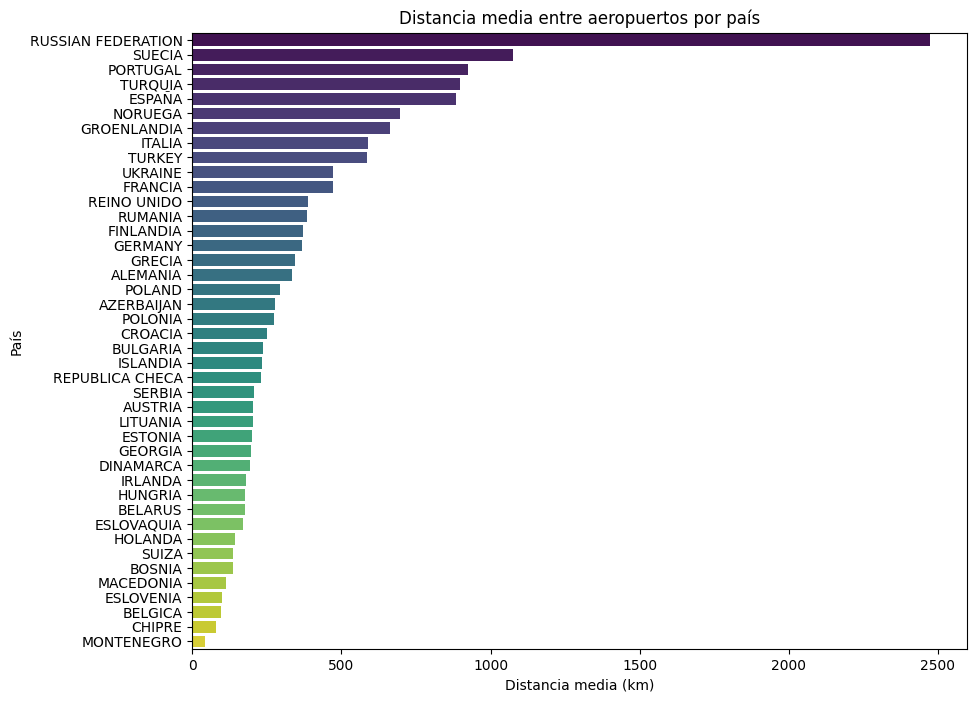

In [70]:
import seaborn as sns # Seaborn mola
import matplotlib.pyplot as plt


# Ordenar el DataFrame por la columna 'Distancia' en orden descendente
df_media_distancias.sort_values('Distancia_Media', 
                                ascending = False,
                                inplace = True)

# Crear la gráfica de barras ordenadas
plt.figure(figsize = (10, 8))
sns.barplot(x = 'Distancia_Media', 
            y = 'Pais', 
            data = df_media_distancias, 
            order = df_media_distancias['Pais'], 
            palette = 'viridis')

# Damos formato a las leyendas
plt.xlabel('Distancia media (km)')
plt.ylabel('País')
plt.title('Distancia media entre aeropuertos por país')
plt.show()

## 3. **Costes asociados a un vuelo**

Tenemos en una tabla **`flights`** la información de dos vuelos `IB1234` y `IB4321`:

- Parece que nos han dejado la información a [nivel cabina](https://es.wikipedia.org/wiki/Cabina_de_avi%C3%B3n) `cabin_code`
- También tiene información de origen y destino (`boardpoint_stn, offpoint_stn`), pasajeros (`pax`) e ingresos.
- Los ingresos están repartidos entre dos conceptos: `gross_revenue` y `yq_surcharge`

Además nos han dejado en otra tabla **`costs`** los costes asociados a dichos vuelos.

---

**Quieren repartir estos costes, que son los totales del vuelo, entre las diferentes cabinas pero no saben cuál sería la forma más correcta. Para ello te piden que repartas estos costes de dos formas:**

- Reparte los costes entre las diferentes cabinas en base al número de pasajeros.
- Reparte los costes entre las diferentes cabinas en base a la suma total de ingresos.
   
***`Calcula lo que pide el departamento de finanzas y presentale los resultados`***

_`Hint:` Nos han dicho que a esta gente de finanzas no les gusta pensar mucho, y prefieren ver resultados de forma gráfica_

In [71]:
# Sacamos la tabla flights del SQL
flights = pd.read_sql_query('select * from flights', conn)
flights

,fligth,boardpoint_stn,offpoint_stn,cabin_code,pax,gross_revenue,yq_surcharge
0,IB1234,MAD,BCN,Y,180,6788.12,4721.10
1,IB1234,MAD,BCN,C,19,1056.43,5021.20
2,IB1234,MAD,BCN,W,9,1000.77,324.43
3,IB4321,MAD,JFK,Y,153,21020.01,11328.11
4,IB4321,MAD,JFK,C,23,9345.34,2987.30
5,IB4321,MAD,JFK,W,12,8111.30,NaN


In [75]:
# Sacamos la tabla costs del SQL
costs = pd.read_sql_query('select * from costs', conn)
costs

,fligth,cost
0,IB1234,9340.01
1,IB4321,31235.20


In [108]:
# Rellenamos el NaN con un 0
flights.fillna(0, inplace = True)

# Creamos una columna con los ingresos totales
flights['total_revenue'] = flights['gross_revenue'] + flights['yq_surcharge']
flights.drop(['gross_revenue', 'yq_surcharge'], 
             axis = 1, 
             inplace = True)

flights

,fligth,boardpoint_stn,offpoint_stn,cabin_code,pax,total_revenue,perc_pax,perc_revenue
0,IB1234,MAD,BCN,Y,180,11509.22,0.865385,0.608565
1,IB1234,MAD,BCN,C,19,6077.63,0.091346,0.321363
2,IB1234,MAD,BCN,W,9,1325.20,0.043269,0.070072
3,IB4321,MAD,JFK,Y,153,32348.12,0.813830,0.612746
4,IB4321,MAD,JFK,C,23,12332.64,0.122340,0.233608
5,IB4321,MAD,JFK,W,12,8111.30,0.063830,0.153646


In [109]:
# Calcular el total de pasajeros por vuelo y de beneficios
total_pax = flights.groupby('fligth')['pax'].transform('sum')
total_revenue = flights.groupby('fligth')['total_revenue'].transform('sum')

# Calcular el porcentaje de pasajeros por vuelo y el porcentaje por beneficio
flights['perc_pax'] = flights['pax'] / total_pax
flights['perc_revenue'] = flights['total_revenue'] / total_revenue

flights

,fligth,boardpoint_stn,offpoint_stn,cabin_code,pax,total_revenue,perc_pax,perc_revenue
0,IB1234,MAD,BCN,Y,180,11509.22,0.865385,0.608565
1,IB1234,MAD,BCN,C,19,6077.63,0.091346,0.321363
2,IB1234,MAD,BCN,W,9,1325.20,0.043269,0.070072
3,IB4321,MAD,JFK,Y,153,32348.12,0.813830,0.612746
4,IB4321,MAD,JFK,C,23,12332.64,0.122340,0.233608
5,IB4321,MAD,JFK,W,12,8111.30,0.063830,0.153646


In [110]:
# Unimos DataFrames flights y costs
finances = pd.merge(flights, costs, 
                    on = 'fligth',
                    how = 'left')
finances

,fligth,boardpoint_stn,offpoint_stn,cabin_code,pax,total_revenue,perc_pax,perc_revenue,cost
0,IB1234,MAD,BCN,Y,180,11509.22,0.865385,0.608565,9340.01
1,IB1234,MAD,BCN,C,19,6077.63,0.091346,0.321363,9340.01
2,IB1234,MAD,BCN,W,9,1325.20,0.043269,0.070072,9340.01
3,IB4321,MAD,JFK,Y,153,32348.12,0.813830,0.612746,31235.20
4,IB4321,MAD,JFK,C,23,12332.64,0.122340,0.233608,31235.20
5,IB4321,MAD,JFK,W,12,8111.30,0.063830,0.153646,31235.20


In [111]:
# Columna pax_cost y revenue_cost donde se reparten los costes en funcion de los pasajeros y los beneficios
finances['pax_cost'] = finances['perc_pax'] * finances['cost']
finances['revenue_cost'] = finances['perc_revenue'] * finances['cost']

finances

,fligth,boardpoint_stn,offpoint_stn,cabin_code,pax,total_revenue,perc_pax,perc_revenue,cost,pax_cost,revenue_cost
0,IB1234,MAD,BCN,Y,180,11509.22,0.865385,0.608565,9340.01,8082.700962,5684.007281
1,IB1234,MAD,BCN,C,19,6077.63,0.091346,0.321363,9340.01,853.173990,3001.532091
2,IB1234,MAD,BCN,W,9,1325.20,0.043269,0.070072,9340.01,404.135048,654.470629
3,IB4321,MAD,JFK,Y,153,32348.12,0.813830,0.612746,31235.20,25420.136170,19139.241731
4,IB4321,MAD,JFK,C,23,12332.64,0.122340,0.233608,31235.20,3821.327660,7296.788133
5,IB4321,MAD,JFK,W,12,8111.30,0.063830,0.153646,31235.20,1993.736170,4799.170136


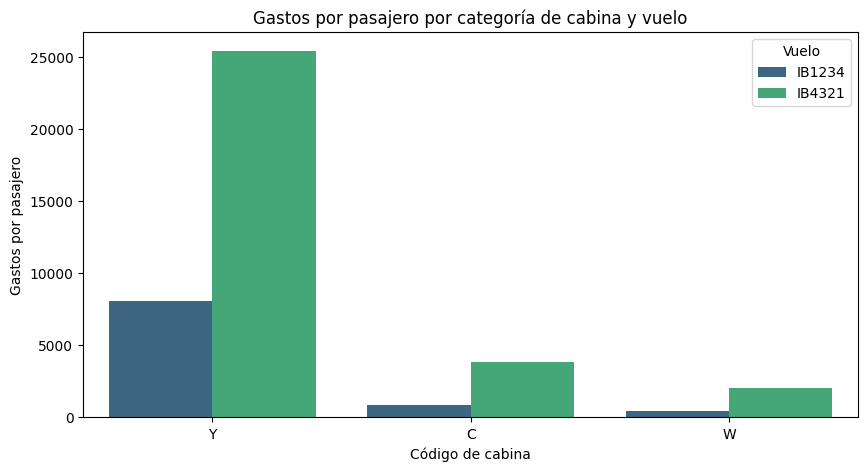

In [122]:
# subgráficas separadas por 'flight' y colores por 'cabin_code'
plt.figure(figsize=(10, 5))
sns.barplot(x = 'cabin_code', 
            y = 'pax_cost', 
            hue = 'fligth', 
            data = finances,
            palette = 'viridis')
plt.xlabel('Código de cabina')
plt.ylabel('Gastos por pasajero')
plt.title('Gastos por pasajero por categoría de cabina y vuelo')
plt.legend(title = 'Vuelo')
plt.show()

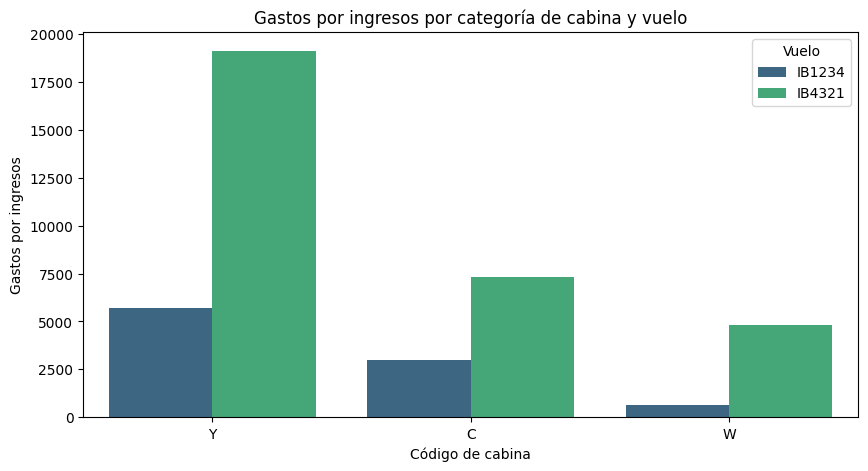

In [131]:
# Crear la gráfica utilizando Seaborn con subgráficas separadas por 'flight' y colores por 'cabin_code'
plt.figure(figsize=(10, 5))
sns.barplot(x = 'cabin_code', 
            y = 'revenue_cost', 
            hue = 'fligth', 
            data = finances,
            palette = 'viridis')
plt.xlabel('Código de cabina')
plt.ylabel('Gastos por ingresos')
plt.title('Gastos por ingresos por categoría de cabina y vuelo')
plt.legend(title = 'Vuelo')
plt.show()

In [128]:
# Las dos graficas en una sola
finances_reduced = finances[['fligth', 'cabin_code', 'pax_cost', 'revenue_cost']]

df_melted = finances_reduced.melt(id_vars=['fligth', 'cabin_code'], 
                                  var_name='cost_type', 
                                  value_name='costs')
df_melted

,fligth,cabin_code,cost_type,costs
0,IB1234,Y,pax_cost,8082.700962
1,IB1234,C,pax_cost,853.173990
2,IB1234,W,pax_cost,404.135048
3,IB4321,Y,pax_cost,25420.136170
4,IB4321,C,pax_cost,3821.327660
5,IB4321,W,pax_cost,1993.736170
6,IB1234,Y,revenue_cost,5684.007281
7,IB1234,C,revenue_cost,3001.532091
8,IB1234,W,revenue_cost,654.470629
9,IB4321,Y,revenue_cost,19139.241731


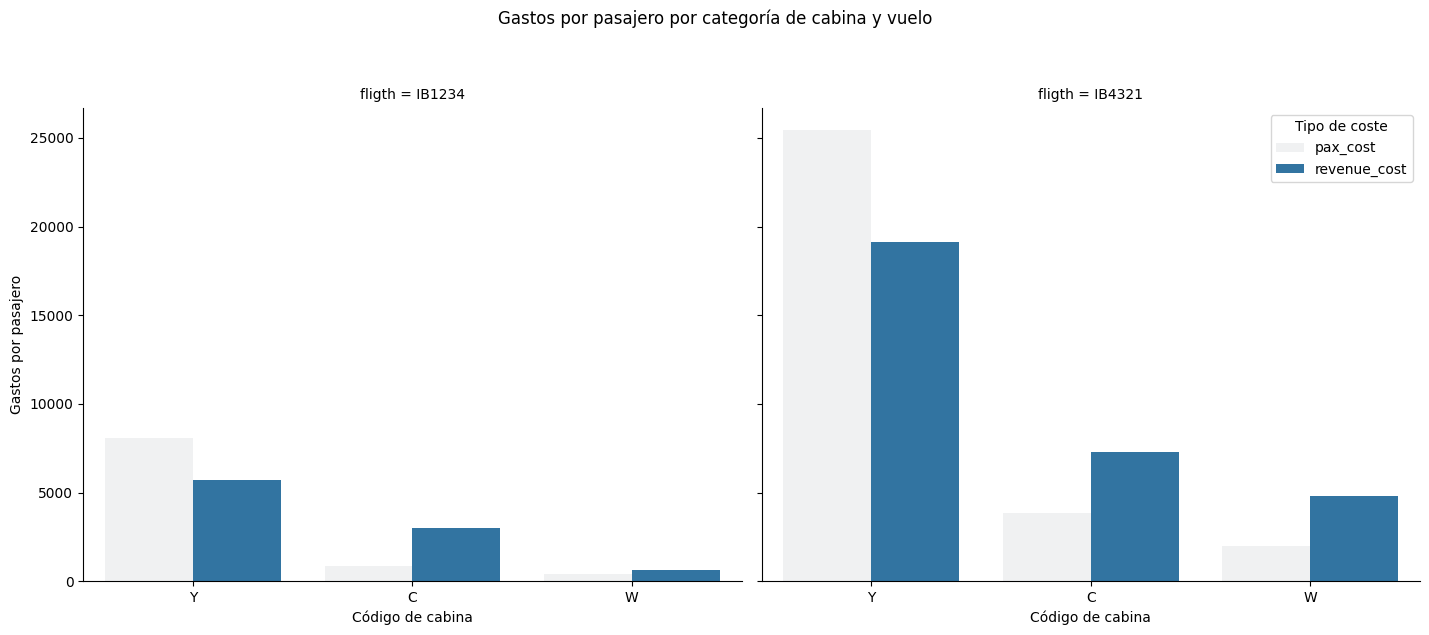

In [134]:
import warnings # salen unos warnings que quedan muy feos asi que los ocultamos
warnings.filterwarnings("ignore")

# Crear la gráfica utilizando Seaborn con subgráficas separadas por 'flight'
g = sns.FacetGrid(df_melted, 
                  col = 'fligth', 
                  height = 6, 
                  aspect = 1.2)
g.map(sns.barplot, 'cabin_code', 'costs', 'cost_type')

# Configuramos las graficas
g.set_axis_labels('Código de cabina', 'Gastos por pasajero')
g.fig.suptitle('Gastos por pasajero por categoría de cabina y vuelo', y=1.05)
plt.legend(title = 'Tipo de coste')
plt.tight_layout()
plt.show()

**Conclusiones** Unas buenas conclusiones que se pueden extraer es que el vuelo IB1234 tiene unos gastos por cabina menos pronunciados haciendo mas cara las cabinas caras en los vuelos de largo recorrido y puede que a Iberia le interese subir el precio de la cabina Y en el vuelo IB4321.